# **1. Intall Dependencies**

---




In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


In [ ]:
!pip list
#make sure we have tesnorflow , opencv python and matplotlib

#**2. Import The Needed Liberies**

---



In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import glob
import numpy as np
import scipy.ndimage as nd
import pandas as pd
from matplotlib import pyplot as plt
import imghdr
import tensorflow_hub as hub
from PIL import Image
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense ,Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision , Recall , SparseCategoricalAccuracy
from tensorflow_datasets import load
from skimage.segmentation import felzenszwalb
from skimage import segmentation as seg
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu , True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
len(gpus)

1

# **3. Removing Doggy images**

---



In [ ]:
# data direcory
dir = '/content/drive/MyDrive/Data'

#Image extension
ex = ['jpg' , 'jpeg' ]

In [ ]:
#Removing any image not in jpg or jpeg format

for img in os.listdir(dir):
  for image in os.listdir(os.path.join(dir , img )):
    img_path = os.path.join(dir , img , image)
    try :
      img1 = cv2.imread(img_path)
      x = imghdr.what(img_path)
      if x not in ex :
        print(img_path,"Removed")
        os.remove(img_path)
    except Exception as e :
      print(e)
      print(img_path)
      os.remove(img_path)

In [ ]:
#check for duplicated images and removes them

def remove_duplicates(dir):
  hash_keys = {}
  duplicates = []
  for img in os.listdir(dir):
    for image in os.listdir(os.path.join(dir, img)):
      img_path = os.path.join(dir, img, image)
      with open(img_path, 'rb') as f:
        filehash = hash(f.read())
      if filehash not in hash_keys:
        hash_keys[filehash] = img_path
      else:
        duplicates.append((img_path, hash_keys[filehash]))
  for img_path, duplicate in duplicates:
    print(f"Removing duplicate image: {img_path}")
    os.remove(img_path)

remove_duplicates(dir)


# **4. Loading Data**

---



212 212


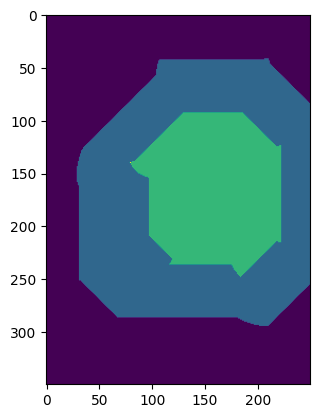

In [ ]:
from PIL import Image
image = cv2.imread('/content/drive/MyDrive/Data/edge-on/100143.jpg')

result = seg.felzenszwalb(image, scale=10, sigma=50, min_size=0)
center_row = image.shape[0] // 2
center_col = image.shape[1] // 2
print(center_row , center_col)
y=50
x=50
h=300
w=400
crop_image = result[x:w, y:h]
plt.imshow(crop_image)

In [ ]:
def segment(img):
  result = seg.felzenszwalb(image, scale=10, sigma=50, min_size=0)
  return result

folders = ['Cigar-shaped smooth', 'completely round smooth', 'edge-on', 'In between smooth', 'spiral']

dir = '/content/drive/MyDrive/Data'


for folder in folders:_

    output_folder = os.path.join('output', folder)
    os.makedirs(output_folder, exist_ok=True)

    images = [cv2.imread(file, 0) for file in glob.glob(os.path.join(dir, folder, '*.jpg'))]

    number = 0
    for image in images:
        final = segment(image)
        colored_segmentation = cv2.applyColorMap((final * 255).astype(np.uint8), cv2.COLORMAP_JET)
        cv2.imwrite(os.path.join(output_folder, 'img{}.jpg'.format(number)), colored_segmentation)
        number += 1

In [ ]:
dir = '/content/output'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(dir)

Found 1000 files belonging to 5 classes.


In [ ]:
class_counts = {}

for images, labels in data:
    for label in labels:
        class_name = data.class_names[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

print(class_counts)


{'spiral': 200, 'edge-on': 200, 'In between smooth': 200, 'Cigar-shaped smooth': 200, 'completely round smooth': 200}


In [ ]:
data_it = data.as_numpy_iterator()

In [ ]:
#insted of handling data one by one we use them as batch
batch = data_it.next()

In [ ]:
#information about the data

print("Shape:", batch[0].shape)
print("Min:" , batch[0].min())
print('Max' , batch[0].max())

Shape: (32, 256, 256, 3)
Min: 0.0
Max 162.0


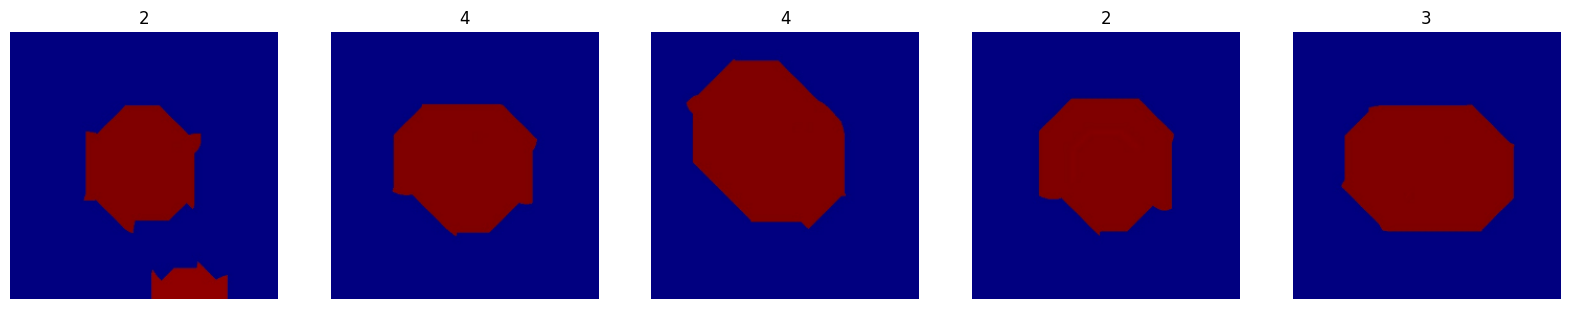

In [ ]:
fig , ax = plt.subplots(ncols = 5 , figsize = (20 , 20))

for x , img in enumerate(batch[0][:5]):
  ax[x].imshow(img.astype(np.uint8))
  ax[x].set_title(batch[1][x])
  ax[x].axis('off')

In [ ]:
labels = data.class_names
for i, label in enumerate(labels):
  print(f"Label {i}: {label}")

Label 0: Cigar-shaped smooth
Label 1: In between smooth
Label 2: completely round smooth
Label 3: edge-on
Label 4: spiral


In [ ]:
classes = ['Cigar-shaped smooth' ,'In between smooth','completely round smooth' , 'edge-on' , 'spiral' ]

# **5. Enhancing & Normalizing Data**

---



In [ ]:
data = data.map(lambda x, y: (tfa.image.sharpness(x, 1.0), y))

In [ ]:
min = batch[0].min()
max = batch[0].max()

print(min , max)

0.0 162.0


In [ ]:
#Sacling values between 0 and 1 (Normalizing)
data = data.map(lambda x,y : (x/(255) , y))

In [ ]:
scaled_it = data.as_numpy_iterator()

In [ ]:
batch = scaled_it.next()

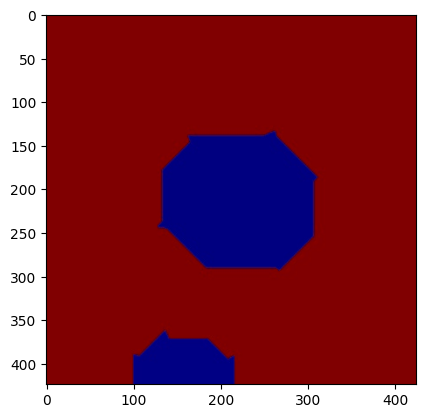

In [ ]:
img = cv2.imread(os.path.join(dir , 'edge-on' , 'img6.jpg'))
plt.imshow(img)

In [ ]:
processing = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.CenterCrop(200 , 200)
]
)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.3),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]

)

In [ ]:
min = batch[0].min()
max = batch[0].max()

print(min , max)

0.0 0.61105525


In [ ]:
data = data.map(lambda x, y: (processing(x, training=True), y))

In [ ]:
data = data.map(lambda x,y :(data_augmentation (x, training = True), y))

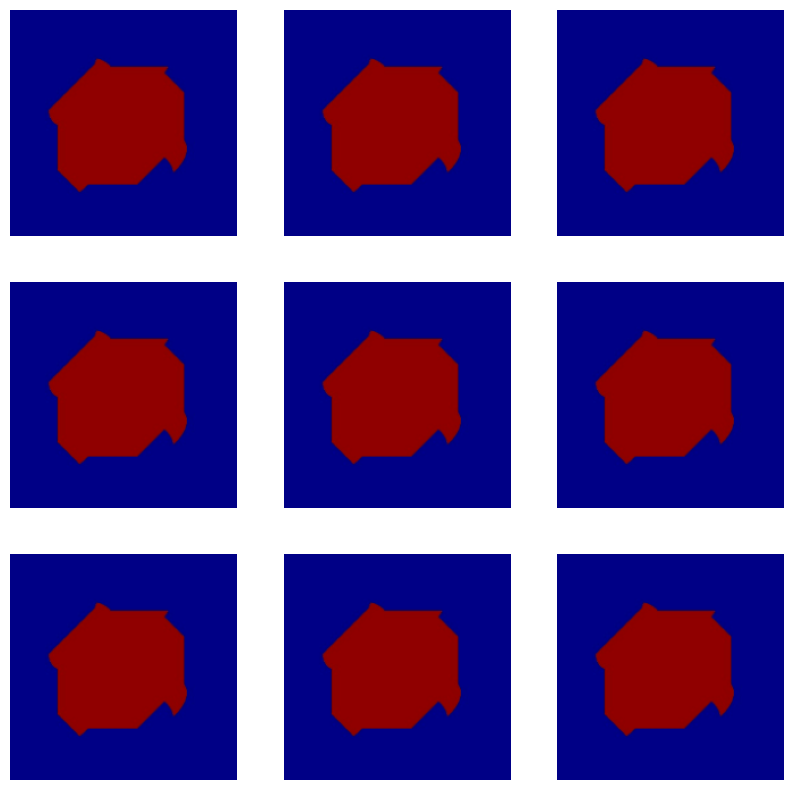

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in data.take(2):
    for i in range(9):
        augmented_images = processing(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0])
        plt.axis("off")

# **6. Split Data**


In [ ]:
len(data)
#number of batches

32

In [ ]:
train_sz = int(len(data) * 0.8)
val_sz = int(len(data) * 0.1)+1
test_sz = int(len(data) * 0.1)


print("Training set size:", train_sz)
print("Validation set size:", val_sz)
print("Test set size:", test_sz)
print(train_sz + val_sz + test_sz)

Training set size: 25
Validation set size: 4
Test set size: 3
32


In [ ]:
data = data.shuffle(buffer_size=1000)

In [ ]:
train = data.take(train_sz)
evaluation = data.skip(train_sz).take(val_sz)
test = data.skip(train_sz).skip(val_sz).take(test_sz)

In [ ]:
len(train)

25

In [ ]:
# Create the output folder
output_folder = 'yolo5'
os.makedirs(output_folder, exist_ok=True)

# Create the train, test, and evaluation folders
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
evaluation_folder = os.path.join(output_folder, 'evaluation')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(evaluation_folder, exist_ok=True)

# Create the class folders for each folder
for folder in classes:
    os.makedirs(os.path.join(train_folder, folder), exist_ok=True)
    os.makedirs(os.path.join(test_folder, folder), exist_ok=True)
    os.makedirs(os.path.join(evaluation_folder, folder), exist_ok=True)

# Move the images to the appropriate folders
for i, (images, labels) in enumerate(train):
    for image, label in zip(images, labels):
        class_folder = classes[label]
        file_name = f'img{i}.jpg'
        shutil.copy(os.path.join('/content/output', class_folder, file_name), os.path.join(train_folder, class_folder, file_name))

for i, (images, labels) in enumerate(test):
    for image, label in zip(images, labels):
        class_folder = classes[label]
        file_name = f'img{i}.jpg'
        shutil.copy(os.path.join('/content/output', class_folder, file_name), os.path.join(test_folder, class_folder, file_name))

for i, (images, labels) in enumerate(evaluation):
    for image, label in zip(images, labels):
        class_folder = classes[label]
        file_name = f'img{i}.jpg'
        shutil.copy(os.path.join('/content/output', class_folder, file_name), os.path.join(evaluation_folder, class_folder, file_name))



In [ ]:
num_classes = 5

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = train.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

print(counts.numpy())


[143 165 163 154 151]


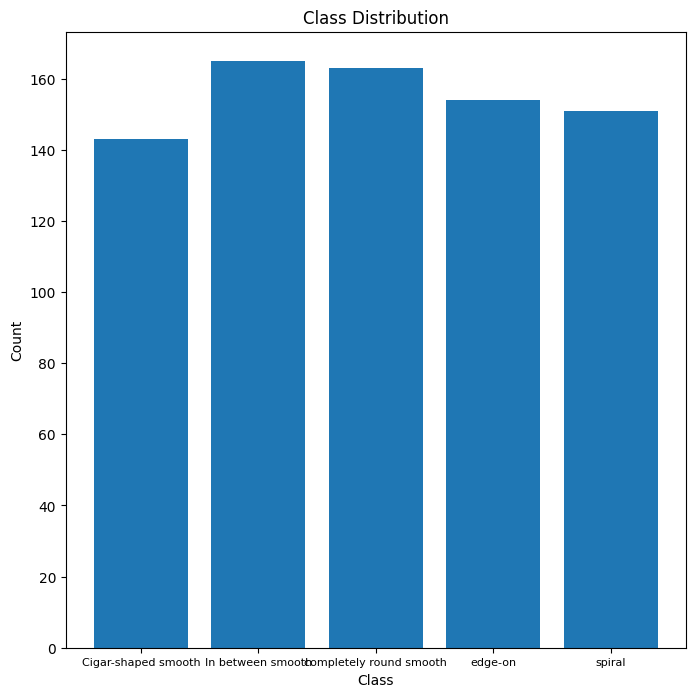

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(range(num_classes), counts.numpy())
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
ax.set_xticks(range(num_classes))
ax.set_xticklabels(classes , size = 8)
plt.show()

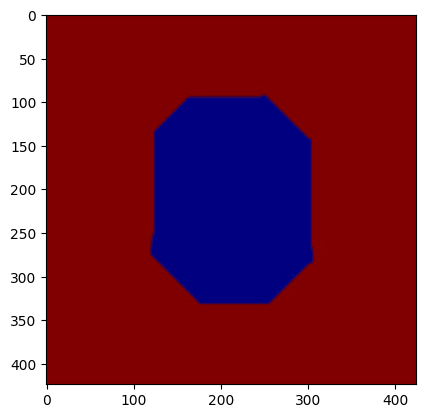

In [ ]:
img = cv2.imread(os.path.join(dir , 'edge-on' , 'img20.jpg'))
plt.imshow(img)

# **7.1 Build Model (CNN)**

---



In [ ]:
model = Sequential()

In [ ]:
#Adding layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 99, 99, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 99, 99, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 32)       

# **7.2 Build Model (YOLO)**

---



In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

In [ ]:
model = YOLO("/content/yolov8n-cls.pt")
model.train(data= "/content/yolo2", epochs=20)

Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=/content/yolov8n-cls.pt, data=/content/yolo2, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /content/yolo2/train... 123 images, 0 corrupt: 100%|██████████| 123/123 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo2/test... 15 images, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train6
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 72.77it/s]

                   all        0.2          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 69.40it/s]

                   all        0.2          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 81.48it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]

                   all        0.4          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]

                   all        0.4          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.398G      1.516         11        224: 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.77it/s]

                   all      0.333          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.398G      1.514         11        224: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 64.04it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.398G      1.484         11        224: 100%|██████████| 8/8 [00:00<00:00, 11.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 73.90it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.398G      1.504         11        224: 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

                   all      0.267          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.398G      1.479         11        224: 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 79.54it/s]

                   all      0.267          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.398G       1.48         11        224: 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 75.56it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.398G      1.452         11        224: 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 80.87it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.398G      1.446         11        224: 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s]

                   all        0.4          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.398G      1.453         11        224: 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.398G      1.451         11        224: 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]

                   all      0.333          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.398G       1.46         11        224: 100%|██████████| 8/8 [00:01<00:00,  6.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]

                   all      0.333          1



20 epochs completed in 0.018 hours.
Optimizer stripped from runs/classify/train6/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train6/weights/best.pt, 3.0MB

Validating runs/classify/train6/weights/best.pt...
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1441285 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/yolo2/train... found 123 images in 5 classes ✅ 
val: None...
test: /content/yolo2/test... found 15 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.42it/s]


                   all        0.4          1
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train6
Results saved to runs/classify/train6


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca407ef1ea0>
curves: []
curves_results: []
fitness: 0.7000000029802322
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.4000000059604645, 'metrics/accuracy_top5': 1.0, 'fitness': 0.7000000029802322}
save_dir: PosixPath('runs/classify/train6')
speed: {'preprocess': 0.06998380025227866, 'inference': 1.1542797088623047, 'loss': 0.0010331471761067708, 'postprocess': 0.00095367431640625}
task: 'classify'
top1: 0.4000000059604645
top5: 1.0

# **8. Train**

---



In [ ]:
loss_instance = model.loss
print(loss_instance)

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
print(train.element_spec)

(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
hist = model.fit(train , epochs = 50 , validation_data =evaluation , callbacks = [tensorboard_callback])

Epoch 1/50
25/25 [==============================] - 44s 2s/step - loss: 0.6523 - accuracy: 0.7513 - val_loss: 0.6206 - val_accuracy: 0.7344
Epoch 2/50
25/25 [==============================] - 42s 2s/step - loss: 0.6584 - accuracy: 0.7307 - val_loss: 0.6081 - val_accuracy: 0.7812
Epoch 3/50
25/25 [==============================] - 40s 1s/step - loss: 0.6878 - accuracy: 0.7275 - val_loss: 0.5882 - val_accuracy: 0.7344
Epoch 4/50
25/25 [==============================] - 39s 1s/step - loss: 0.6168 - accuracy: 0.7397 - val_loss: 0.5828 - val_accuracy: 0.7344
Epoch 5/50
25/25 [==============================] - 40s 1s/step - loss: 0.6717 - accuracy: 0.7450 - val_loss: 0.6053 - val_accuracy: 0.7578
Epoch 6/50
25/25 [==============================] - 43s 2s/step - loss: 0.6291 - accuracy: 0.7307 - val_loss: 0.5084 - val_accuracy: 0.8173
Epoch 7/50
25/25 [==============================] - 42s 1s/step - loss: 0.6805 - accuracy: 0.7010 - val_loss: 0.5481 - val_accuracy: 0.8281
Epoch 8/50
25/25 [==

# **9. Plot Performance**

---



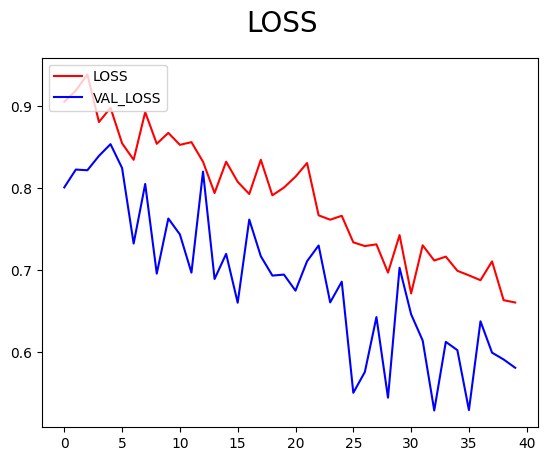

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'] , color='red' , label = 'LOSS')
plt.plot(hist.history['val_loss'], color = 'blue' , label = 'VAL_LOSS')
fig.suptitle('LOSS' , fontsize = 20)
plt.legend(loc='upper left')
plt.show()

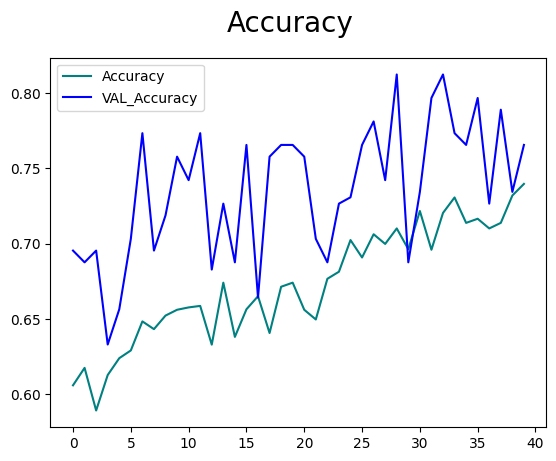

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'] , color='teal' , label = 'Accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue' , label = 'VAL_Accuracy')
fig.suptitle('Accuracy' , fontsize = 20)
plt.legend(loc='upper left')
plt.show()

# **10. Evaluating Performance**

---



In [ ]:
model_accuracy = model.evaluate(test)[1]
print(f"Model accuracy on test set: {model_accuracy:.2f}")

3/3 [==============================] - 8s 282ms/step - loss: 0.3127 - accuracy: 0.9167
Model accuracy on test set: 0.92


In [ ]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)

    # Convert predictions to most likely class labels
    yhat_labels = tf.argmax(yhat, axis=1)

    pre.update_state(y, yhat_labels)
    re.update_state(y, yhat_labels)
    acc.update_state(y, yhat)

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

1/1 [==============================] - 0s 303ms/step
Precision: 0.91082805
Recall: 0.9711375
Accuracy: 0.7325269


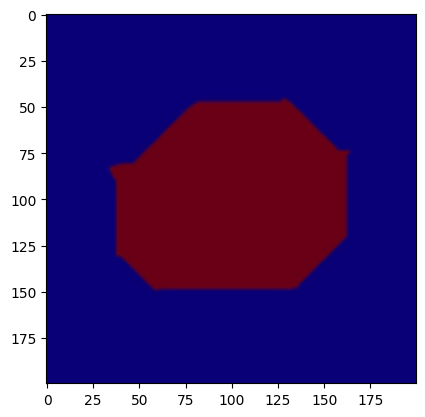

Actual label: edge-on
1/1 [==============================] - 0s 298ms/step
Predicted label: edge-on


In [ ]:
for img_batch, label_batch in test.take(1):
    first_img = img_batch[0].numpy()
    first_label = label_batch.numpy()

    plt.imshow(first_img)
    plt.show()
    print('Actual label:', classes[first_label[0]])

    batch_pred = model.predict(img_batch)
    predicted_label_index = np.argmax(batch_pred[0])
    print('Predicted label:', classes[predicted_label_index])

# **11. Testing the data**

---



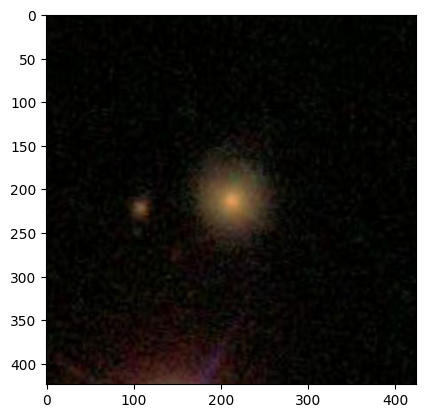

In [ ]:
#testing a random image that is not in the dataset

img1 = cv2.imread('t.jpg')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

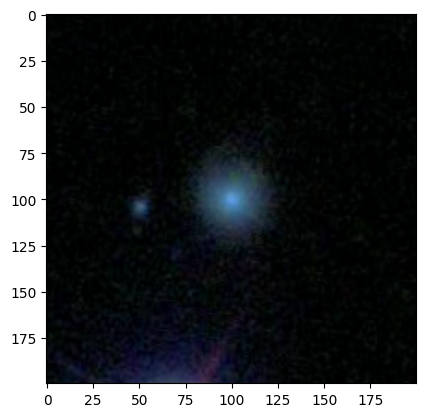

In [ ]:
rsz = tf.image.resize(img1 , (200,200))
plt.imshow(rsz.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(rsz/255 ,0))

1/1 [==============================] - 0s 35ms/step


In [ ]:
yhat

array([[0.03313477, 0.12855656, 0.48320934, 0.33453184, 0.02056738]],
      dtype=float32)

In [ ]:
classes

['Cigar-shaped smooth',
 'In between smooth',
 'completely round smooth',
 'edge-on',
 'spiral']

In [ ]:
highest_value = np.max(yhat)
class_index = np.argmax(yhat)
class_name = classes[class_index]

print("Highest value:", highest_value)
print("Predicted class label:", class_name)


Highest value: 0.48320934
Class: completely round smooth


# **12. Saving the model**

---



In [ ]:
model.save(os.path.join('models','GalaxyCNN.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
